In [42]:
import sys
import xarray as xr
import numpy as np
from climada.entity import Exposures
from pathlib import Path
import os
from cartopy import crs as ccrs

MAP_PROJECTION = ccrs.EckertIII()

project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from source.config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

PATH_FIGURES = Path("/cluster/project/climate/szelie/lancet_countdown/figures")
    
POP_PATH = DATA_SRC / 'lancet/population/hybrid_2024'
RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'results'/ f'results_{2023+1}'

hw =  [xr.open_dataset(RESULTS_FOLDER / f"heatwave_days_era5/indicator_{year}.nc") for year in np.arange(1980,2024)]
elderly = xr.open_dataset( POP_PATH / f'worldpop_elderly_1950_2023_era5_compatible.nc')
elderly = elderly.sel(year=slice(1980,2024))
infants = xr.open_dataset( POP_PATH / f'worldpop_infants_1950_2023_era5_compatible.nc')
infants = infants.sel(year=slice(1980,2024))
hw = xr.concat(hw, dim="year")


1. select two periods
2. get average heatwave day during each period per grid point
3. get average number of people during each period per grid point
4. multiply each combination per grid point --> average heatwave day * person per grid point
5. sum --> average heatwave day * person globally 
6. relative difference

In [2]:
RESULTS_FOLDER

PosixPath('/nfs/n2o/wcr/szelie/lancet/results/results_2024')

In [51]:
hw = hw.sortby('latitude')
# mean number of heatwave days per grid point for each period
climate_period1 = hw.transpose("latitude","longitude","year")['heatwaves_days'].sel(year=slice(1986,2005)).mean(dim="year")
climate_period2 = hw.transpose("latitude","longitude","year")['heatwaves_days'].sel(year=slice(2005,2023)).mean(dim="year")
# mean number of people per grid point for each period
elderly_period1 = elderly.sel(year=slice(1986,2005)).mean(dim="year") 
elderly_period2 = elderly.sel(year=slice(2004,2023)).mean(dim="year")
infants_period1 = infants.sel(year=slice(1986,2005)).mean(dim="year")
infants_period2 =  infants.sel(year=slice(2004,2023)).mean(dim="year")

# # Set areas with a population of 0 to NaN for elderly
elderly_period1 = elderly_period1.where(elderly_period1 > 1, np.nan)
elderly_period2 = elderly_period2.where(elderly_period2 > 1, np.nan)

# # Set areas with a population of 0 to NaN for infants
# infants_period1 = infants_period1.where(infants_period1 > 1, np.nan)
# infants_period2 = infants_period2.where(infants_period2 > 1, np.nan)


# Calculating the effect for elderly
days_person_elderly_period1 = climate_period1 * elderly_period1
days_person_elderly_period2 = climate_period2 * elderly_period2
# Calculating the effect for infants
days_person_infants_period1 = climate_period1 * infants_period1
days_person_infants_period2 = climate_period2 * infants_period2

# Calculating the increase due to climate change for each group
increase_elderly_climate = elderly_period1 * (climate_period2 - climate_period1)
increase_infants_climate = infants_period1 * (climate_period2 - climate_period1)

# Calculating the increase due to population growth for each group
increase_elderly_population = (elderly_period2 - elderly_period1) * climate_period1
increase_infants_population = (infants_period2* climate_period1 - infants_period1* climate_period1) 

# Calculating the combined effect of climate change and population growth for each group
combined_increase_elderly = days_person_elderly_period2 - days_person_elderly_period1
combined_increase_infants = days_person_infants_period2 - days_person_infants_period1


percentage_increase_elderly_population = increase_elderly_population.sum()/((days_person_elderly_period1).sum())*100
percentage_increase_infants_population = increase_infants_population.sum()/((days_person_infants_period1).sum())*100

percentage_increase_elderly_climate = increase_elderly_climate.sum()/((days_person_elderly_period1).sum())*100
percentage_increase_infants_climate = increase_infants_climate.sum()/((days_person_infants_period1).sum())*100

percentage_increase_elderly = combined_increase_elderly.sum()/((days_person_elderly_period1).sum())*100
percentage_increase_infants = combined_increase_infants.sum()/((days_person_infants_period1).sum())*100

In [68]:
increase_infants_population['infants']

<xarray.DataArray 'infants' (latitude: 721, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * latitude              (latitude) float64 -90.0 -89.75 -89.5 ... 89.75 90.0
  * longitude             (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    age_band_lower_bound  int32 0

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming increase_infants_population is your loaded xarray DataArray
# For this example, let's pretend it's already loaded and named increase_infants_population
increase_infants_population = increase_infants_population.assign_coords(longitude=(((increase_infants_population.longitude + 180) % 360) - 180)).sortby('longitude')

# Set up the map projection
proj = ccrs.PlateCarree()

# Create the figure and add the geographical map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': proj})


# Add coastlines for reference
ax.coastlines()

increase_infants_population['infants'].plot(vmin=-1000, vmax=1000, ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')

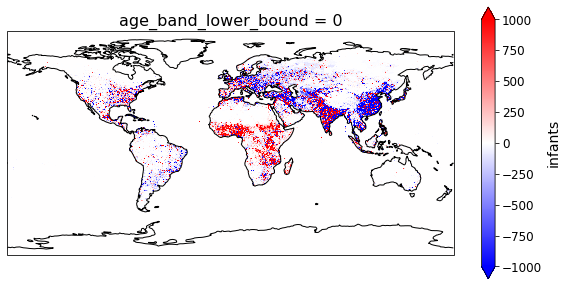

In [75]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming increase_infants_population is your loaded xarray DataArray
# For this example, let's pretend it's already loaded and named increase_infants_population
increase_infants_population = increase_infants_population.assign_coords(longitude=(((increase_infants_population.longitude + 180) % 360) - 180)).sortby('longitude')

# Set up the map projection
proj = ccrs.PlateCarree()

# Create the figure and add the geographical map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': proj})


# Add coastlines for reference
ax.coastlines()

increase_infants_population['infants'].plot(vmin=-1000, vmax=1000, ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')

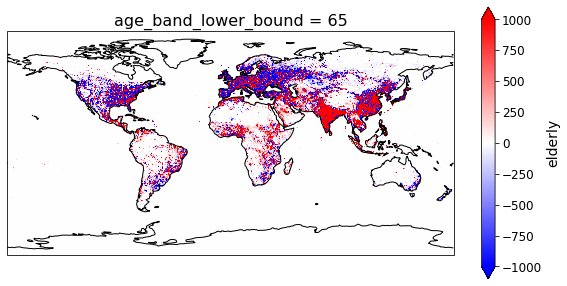

In [97]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming increase_infants_population is your loaded xarray DataArray
# For this example, let's pretend it's already loaded and named increase_infants_population
increase_elderly_population = increase_elderly_population.assign_coords(longitude=(((increase_elderly_population.longitude + 180) % 360) - 180)).sortby('longitude')

# Set up the map projection
proj = ccrs.PlateCarree()

# Create the figure and add the geographical map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': proj})


# Add coastlines for reference
ax.coastlines()

increase_elderly_population['elderly'].plot(vmin=-1000, vmax=1000, ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')

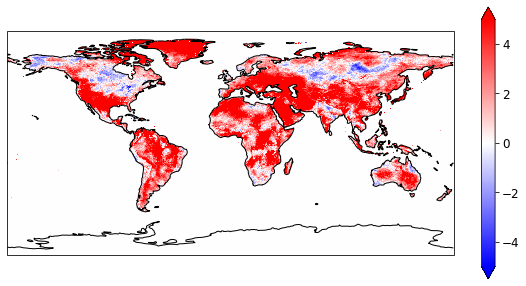

In [100]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
countries_raster = xr.open_dataset(DATA_SRC / 'lancet' / 'admin_boundaries' / 'admin0_raster_report_2024.nc')
# Assuming increase_infants_population is your loaded xarray DataArray
# For this example, let's pretend it's already loaded and named increase_infants_population
diff = climate_period2-climate_period1
land_mask = countries_raster['OBJECTID'] <2000

diff = diff.assign_coords(longitude=(((diff.longitude + 180) % 360) - 180)).sortby('longitude')
diff = diff *land_mask
# Set up the map projection
proj = ccrs.PlateCarree()

# Create the figure and add the geographical map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': proj})


# Add coastlines for reference
ax.coastlines()

diff.plot(vmax=5,vmin=-5, ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming increase_infants_population is your loaded xarray DataArray
# For this example, let's pretend it's already loaded and named increase_infants_population
increase_infants_population = increase_infants_population.assign_coords(longitude=(((increase_infants_population.longitude + 180) % 360) - 180)).sortby('longitude')

# Set up the map projection
proj = ccrs.PlateCarree()

# Create the figure and add the geographical map
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': proj})


# Add coastlines for reference
ax.coastlines()

increase_infants_population['infants'].plot(vmin=-1000, vmax=1000, ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')

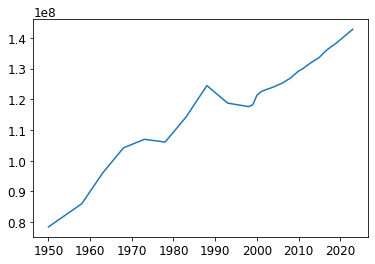

In [18]:
fig, ax = plt.subplots()
ax.plot(infants.year, infants.sum(dim=('latitude', 'longitude'))['infants'])

In [4]:
increase_elderly_population_gdf = increase_elderly_population.to_dataframe().reset_index()
increase_infants_population_gdf = increase_infants_population.to_dataframe().reset_index()

In [5]:
increase_elderly_climate_gdf = increase_elderly_climate.to_dataframe().reset_index()
increase_infants_climate_gdf = increase_infants_climate.to_dataframe().reset_index()

In [6]:
combined_increase_elderly_gdf = combined_increase_elderly.to_dataframe().reset_index()
combined_increase_infants_gdf = combined_increase_infants.to_dataframe().reset_index()

In [7]:
# global_increase_elderly_climate = increase_elderly_climate.sum(dim=['latitude', 'longitude']).mean(dim='year')
# global_increase_elderly_population = increase_elderly_population.sum(dim=['latitude', 'longitude']).mean(dim='year')
# global_combined_increase_elderly = combined_increase_elderly.sum(dim=['latitude', 'longitude']).mean(dim='year')

# global_increase_infants_climate = increase_infants_climate.sum(dim=['latitude', 'longitude']).mean(dim='year')
# global_increase_infants_population = increase_infants_population.sum(dim=['latitude', 'longitude']).mean(dim='year')
# global_combined_increase_infants = combined_increase_infants.sum(dim=['latitude', 'longitude']).mean(dim='year')


In [50]:
increase_infants_population.sum()

<xarray.Dataset>
Dimensions:               ()
Coordinates:
    age_band_lower_bound  int32 0
Data variables:
    infants               float64 -2.21e+06

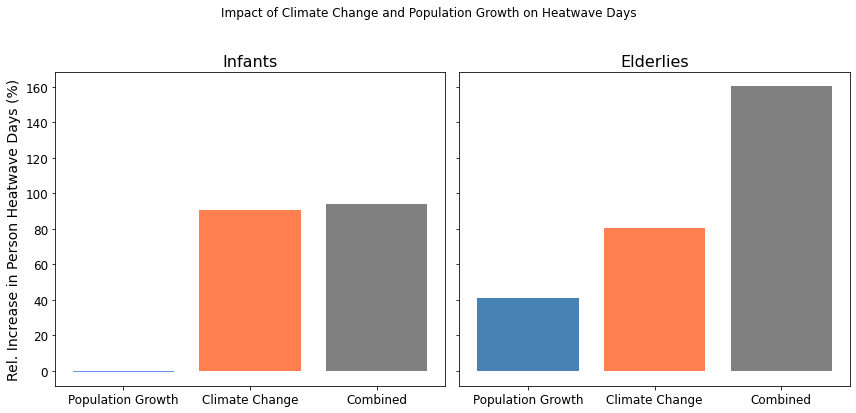

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 14, 'axes.titlesize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


# Data for plotting
impact_factors = ['Population Growth', 'Climate Change', 'Combined']
elderly_values = [percentage_increase_elderly_population['elderly'].data, percentage_increase_elderly_climate['elderly'].data, percentage_increase_elderly['elderly'].data]
infants_values = [percentage_increase_infants_population['infants'].data, percentage_increase_infants_climate['infants'].data, percentage_increase_infants['infants'].data]

x = np.arange(len(impact_factors))  # the label locations

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plotting for Elderly
axs[0].bar(x, infants_values, color=['cornflowerblue', 'coral', 'gray'])
axs[0].set_title('Infants')
axs[0].set_xticks(x)
axs[0].set_xticklabels(impact_factors)
axs[0].set_ylabel('Rel. Increase in Person Heatwave Days (%)')

# # Plotting for Infants
axs[1].bar(x, elderly_values, color=['steelblue', 'coral', 'gray'])
axs[1].set_title('Elderlies')
axs[1].set_xticks(x)
axs[1].set_xticklabels(impact_factors)

# Adding some general titles and labels
plt.suptitle('Impact of Climate Change and Population Growth on Heatwave Days')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the suptitle

plt.savefig(PATH_FIGURES/ "barplots_dominant_effect_change.pdf")


dominant effect: check per grid point what is the dominant effect based on the average of this period

In [30]:
infants_values

[array(-0.43519383), array(90.61425032), array(93.77583528)]

In [29]:
elderly_values

[array(40.90284741), array(80.68765278), array(160.44297874)]

## check country shapefile

In [9]:
from shapely.geometry import Point
import geopandas as gpd
increase_elderly_population_gdf['adjusted_longitude'] = increase_elderly_population_gdf['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(increase_elderly_population_gdf.adjusted_longitude, increase_elderly_population_gdf.latitude)]
#increase_elderly_population_gdf = increase_elderly_population_gdf.drop(['Lon', 'Lat'], axis=1)
increase_elderly_population_gdf = gpd.GeoDataFrame(increase_elderly_population_gdf, crs="EPSG:4326", geometry=geometry)
increase_elderly_climate_gdf = gpd.GeoDataFrame(increase_elderly_climate_gdf, crs="EPSG:4326", geometry=geometry)


In [10]:
gdf_countries = gpd.read_file("/nfs/n2o/wcr/szelie/lancet/admin_boundaries/Detailed_Boundary_ADM0")

increase_elderly_population_country = gpd.sjoin(increase_elderly_population_gdf, gdf_countries, how="inner", predicate='within')
increase_elderly_population_country = increase_elderly_population_country[['geometry', 'elderly', 'ISO_3_CODE']]
increase_elderly_population_country = increase_elderly_population_country.groupby('ISO_3_CODE').sum().reset_index()
increase_elderly_climate_country = gpd.sjoin(increase_elderly_climate_gdf, gdf_countries, how="inner", predicate='within')
increase_elderly_climate_country = increase_elderly_climate_country[['geometry', 'elderly', 'ISO_3_CODE']]
increase_elderly_climate_country = increase_elderly_climate_country.groupby('ISO_3_CODE').sum().reset_index()


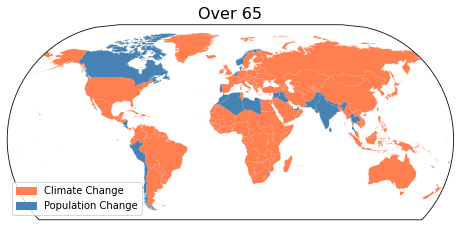

In [32]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

increase_elderly_climate_country = increase_elderly_climate_country.rename(columns={'elderly':'climate_change'})
increase_elderly_population_country = increase_elderly_population_country.rename(columns={'elderly':'population_change'})

dominant_effect_elderly = pd.merge(increase_elderly_climate_country,increase_elderly_population_country)

# Determine the dominant effect for each country
dominant_effect_elderly['dominant_effect'] = dominant_effect_elderly.apply(lambda x: 'Population Change' if x['population_change'] > x['climate_change'] 
                                                                               else 'Climate Change', axis=1)

dominant_effect_elderly = pd.merge(gdf_countries[['geometry', 'ISO_3_CODE']], dominant_effect_elderly, how='outer')
dominant_effect_elderly = gpd.GeoDataFrame(dominant_effect_elderly, geometry=dominant_effect_elderly.geometry)
# Merge the geospatial data with your dataframe on the ISO codes
color_map={'Climate Change':'coral', 'Population Change':'steelblue'}
# Plot the map

fig, ax = plt.subplots(1, 1, figsize=(8,6), subplot_kw=dict(projection=MAP_PROJECTION))
#merged_gdf.plot(column='dominant_effect', ax=ax, legend=True)
patches = []
for effect, color in color_map.items():
    dominant_effect_elderly[dominant_effect_elderly['dominant_effect'] == effect].plot(ax=ax, color=color, transform=ccrs.PlateCarree())
    patches.append(mpatches.Patch(color=color, label=effect))

# Add the legend with the custom patches
ax.legend(handles=patches, loc='lower left')

# Optional: Set additional options for the plot
ax.set_title('Over 65')
#ax.set_axis_off()
plt.savefig(PATH_FIGURES / "dominant_effect_change_countries_elderlies.pdf")


In [13]:
gdf_countries['ISO_3_CODE']

0      ABW
1      AFG
2      AGO
3      AIA
4      ARE
      ... 
236    GRL
237    CUB
238    TON
239    ESH
240    SYR
Name: ISO_3_CODE, Length: 241, dtype: object

In [14]:
from shapely.geometry import Point
import geopandas as gpd
increase_infants_population_gdf['adjusted_longitude'] = increase_infants_population_gdf['longitude'].apply(lambda x: x - 360 if x > 180 else x)

geometry = [Point(xy) for xy in zip(increase_infants_population_gdf.adjusted_longitude, increase_infants_population_gdf.latitude)]
#increase_elderly_population_gdf = increase_elderly_population_gdf.drop(['Lon', 'Lat'], axis=1)
increase_infants_population_gdf = gpd.GeoDataFrame(increase_infants_population_gdf, crs="EPSG:4326", geometry=geometry)
increase_infants_climate_gdf = gpd.GeoDataFrame(increase_infants_climate_gdf, crs="EPSG:4326", geometry=geometry)
combined_increase_infants_gdf = gpd.GeoDataFrame(combined_increase_infants_gdf, crs="EPSG:4326", geometry=geometry)

In [15]:
gdf_countries = gpd.read_file("/nfs/n2o/wcr/szelie/lancet/admin_boundaries/Detailed_Boundary_ADM0")

increase_infants_population_country = gpd.sjoin(increase_infants_population_gdf, gdf_countries, how="inner", predicate='within')
increase_infants_population_country = increase_infants_population_country[['geometry', 'infants', 'ISO_3_CODE']]
increase_infants_population_country = increase_infants_population_country.groupby('ISO_3_CODE').sum().reset_index()
increase_infants_climate_country = gpd.sjoin(increase_infants_climate_gdf, gdf_countries, how="inner", predicate='within')
increase_infants_climate_country = increase_infants_climate_country[['geometry', 'infants', 'ISO_3_CODE']]
increase_infants_climate_country = increase_infants_climate_country.groupby('ISO_3_CODE').sum().reset_index()


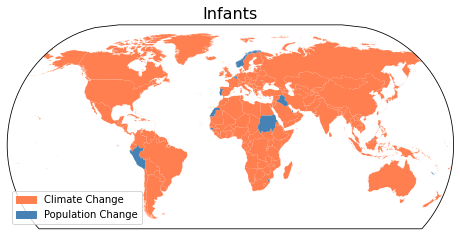

In [33]:
import pandas as pd
import matplotlib.patches as mpatches


increase_infants_climate_country = increase_infants_climate_country.rename(columns={'infants':'climate_change'})
increase_infants_population_country = increase_infants_population_country.rename(columns={'infants':'population_change'})

dominant_effect_infants = pd.merge(increase_infants_climate_country, increase_infants_population_country)

# Determine the dominant effect for each country
dominant_effect_infants['dominant_effect'] = dominant_effect_infants.apply(lambda x: 'Population Change' if x['population_change'] > x['climate_change'] 
                                                                               else 'Climate Change', axis=1)

dominant_effect_infants = pd.merge(gdf_countries[['geometry', 'ISO_3_CODE']], dominant_effect_infants)
dominant_effect_infants = gpd.GeoDataFrame(dominant_effect_infants, geometry=dominant_effect_infants.geometry)
# Merge the geospatial data with your dataframe on the ISO codes
color_map={'Climate Change':'coral', 'Population Change':'steelblue'}
# Plot the map

fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=MAP_PROJECTION))
#merged_gdf.plot(column='dominant_effect', ax=ax, legend=True)
patches = []
for effect, color in color_map.items():
    dominant_effect_infants[dominant_effect_infants['dominant_effect'] == effect].plot(ax=ax, color=color, transform=ccrs.PlateCarree())
    patches.append(mpatches.Patch(color=color, label=effect))

# Add the legend with the custom patches
ax.legend(handles=patches, loc='lower left')

# Optional: Set additional options for the plot
ax.set_title('Infants')
#ax.set_axis_off()

plt.savefig(PATH_FIGURES / "dominant_effect_change_countries_infants.pdf")


In [17]:
import geopandas as gpd

# Step 1: Rename columns for clarity
increase_infants_population_gdf.rename(columns={'infants': 'infants_population_growth'}, inplace=True)
increase_infants_climate_gdf.rename(columns={'infants': 'infants_climate_effect'}, inplace=True)

# Assuming the GeoDataFrames are spatially aligned, we directly combine the data.
# If they are not aligned, you might need a spatial join or another method to ensure alignment.

# Step 2: Combine data into a new DataFrame
combined_df = increase_infants_population_gdf[['geometry', 'infants_population_growth']].copy()
combined_df['infants_climate_effect'] = increase_infants_climate_gdf['infants_climate_effect'].values

# Drop rows where either effect is NaN to ensure we only compare complete data
combined_df.dropna(subset=['infants_population_growth', 'infants_climate_effect'], inplace=True)

# Step 3: Determine the dominant effect
combined_df['dominant_effect'] = combined_df.apply(
    lambda row: 'Population Change' if row['infants_population_growth'] > row['infants_climate_effect'] 
    else 'Climate Change', 
    axis=1
)

# Step 4: Create a new GeoDataFrame with the dominant effect
dominant_effect_gdf_infants = gpd.GeoDataFrame(combined_df, geometry='geometry')
dominant_effect_gdf_infants.crs = increase_infants_population_gdf.crs  # Match the CRS with the original GDF

# Optionally, to view or save this GeoDataFrame:
print(dominant_effect_gdf_infants.head())  # To display the first few rows
# dominant_effect_gdf_infants.to_file("path_to_save_file.geojson", driver='GeoJSON')  # To save to a file


                           geometry  infants_population_growth  \
360      POINT (90.00000 -90.00000)             -177848.812500   
1080    POINT (-90.00000 -90.00000)               12502.734375   
202767  POINT (-68.25000 -55.00000)                   0.714080   
202768  POINT (-68.00000 -55.00000)                  -0.277439   
202769  POINT (-67.75000 -55.00000)                  -0.633038   

        infants_climate_effect dominant_effect  
360              438927.611842  Climate Change  
1080             111210.813836  Climate Change  
202767                2.159219  Climate Change  
202768                2.165499  Climate Change  
202769                5.622301  Climate Change  


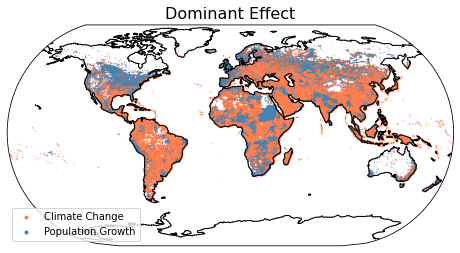

In [18]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs  # Import Cartopy's coordinate reference systems
import cartopy

# Assuming dominant_effect_gdf_infants is your GeoDataFrame
# and it has a column named 'dominant_effect'

# Filter the GeoDataFrame for each dominant effect
population_growth_dominant = dominant_effect_gdf_infants[dominant_effect_gdf_infants['dominant_effect'] == 'Population Change']
climate_effect_dominant = dominant_effect_gdf_infants[dominant_effect_gdf_infants['dominant_effect'] == 'Climate Change']

# Create the plot with Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': MAP_PROJECTION})
ax.coastlines()  # Add coastlines

# Since GeoPandas plots don't automatically adhere to Cartopy's projection,
# we transform the geometries to the correct projection with `.to_crs()`
climate_effect_dominant.to_crs(epsg=4326).plot(ax=ax, marker='o', color='coral', markersize=0.01, label='Climate Change', categorical=True, transform=ccrs.PlateCarree())
population_growth_dominant.to_crs(epsg=4326).plot(ax=ax, marker='o', color='steelblue', markersize=0.01, label='Population Growth', categorical=True, transform=ccrs.PlateCarree())

# Customize the plot
ax.set_title('Dominant Effect')
#ax.set_global()  # Optionally set a global extent
ax.add_feature(cartopy.feature.COASTLINE, linestyle=':')  # Add country borders for better context
plt.legend(markerscale=30)  # Increase marker scale in legend for better visibility

plt.savefig(PATH_FIGURES / "dominant_effect_change_grid_infants.jpeg", dpi=1200)


In [19]:
increase_elderly_population_gdf

,latitude,longitude,age_band_lower_bound,elderly,adjusted_longitude,geometry
0,-90.0,0.00,65,NaN,0.00,POINT (0.00000 -90.00000)
1,-90.0,0.25,65,NaN,0.25,POINT (0.25000 -90.00000)
2,-90.0,0.50,65,NaN,0.50,POINT (0.50000 -90.00000)
3,-90.0,0.75,65,NaN,0.75,POINT (0.75000 -90.00000)
4,-90.0,1.00,65,NaN,1.00,POINT (1.00000 -90.00000)
...,...,...,...,...,...,...
1038235,90.0,358.75,65,NaN,-1.25,POINT (-1.25000 90.00000)
1038236,90.0,359.00,65,NaN,-1.00,POINT (-1.00000 90.00000)
1038237,90.0,359.25,65,NaN,-0.75,POINT (-0.75000 90.00000)
1038238,90.0,359.50,65,NaN,-0.50,POINT (-0.50000 90.00000)


In [20]:
combined_df

,geometry,infants_population_growth,infants_climate_effect,dominant_effect
360,POINT (90.00000 -90.00000),-177848.812500,438927.611842,Climate Change
1080,POINT (-90.00000 -90.00000),12502.734375,111210.813836,Climate Change
202767,POINT (-68.25000 -55.00000),0.714080,2.159219,Climate Change
202768,POINT (-68.00000 -55.00000),-0.277439,2.165499,Climate Change
202769,POINT (-67.75000 -55.00000),-0.633038,5.622301,Climate Change
...,...,...,...,...
948731,POINT (-57.25000 74.50000),5.352854,242.675041,Climate Change
957340,POINT (-65.00000 76.00000),-0.713621,33.593570,Climate Change
960148,POINT (-83.00000 76.50000),-2.408078,18.212525,Climate Change
965962,POINT (-69.50000 77.50000),-1.488735,20.003422,Climate Change


In [21]:
import geopandas as gpd

# Step 1: Rename columns for clarity
increase_elderly_population_gdf.rename(columns={'elderly': 'eldery_population_growth'}, inplace=True)
increase_elderly_climate_gdf.rename(columns={'elderly': 'elderly_climate_effect'}, inplace=True)

# Assuming the GeoDataFrames are spatially aligned, we directly combine the data.
# If they are not aligned, you might need a spatial join or another method to ensure alignment.

# Step 2: Combine data into a new DataFrame
combined_df = increase_elderly_population_gdf[['geometry', 'eldery_population_growth']].copy()
combined_df['elderly_climate_effect'] = increase_elderly_climate_gdf['elderly_climate_effect'].values

# Drop rows where either effect is NaN to ensure we only compare complete data
combined_df.dropna(subset=['eldery_population_growth', 'elderly_climate_effect'], inplace=True)

# Step 3: Determine the dominant effect
combined_df['dominant_effect'] = combined_df.apply(
    lambda row: 'Population Change' if row['eldery_population_growth'] > row['elderly_climate_effect'] 
    else 'Climate Change', 
    axis=1
)

# Step 4: Create a new GeoDataFrame with the dominant effect
dominant_effect_gdf_elderly = gpd.GeoDataFrame(combined_df, geometry='geometry')
dominant_effect_gdf_elderly.crs = increase_elderly_population_gdf.crs  # Match the CRS with the original GDF

# Optionally, to view or save this GeoDataFrame:
print(dominant_effect_gdf_elderly.head())  # To display the first few rows
# dominant_effect_gdf_infants.to_file("path_to_save_file.geojson", driver='GeoJSON')  # To save to a file


                           geometry  eldery_population_growth  \
360      POINT (90.00000 -90.00000)             870662.062500   
1080    POINT (-90.00000 -90.00000)             425172.750000   
198450  POINT (-67.50000 -55.75000)                  3.806426   
198451  POINT (-67.25000 -55.75000)                  3.718611   
199885  POINT (-68.75000 -55.50000)                  2.219038   

        elderly_climate_effect    dominant_effect  
360              800113.048520  Population Change  
1080             509311.697368     Climate Change  
198450               -1.453420  Population Change  
198451               -1.320998  Population Change  
199885               -0.151209  Population Change  


In [22]:
PATH_FIGURES

PosixPath('/cluster/project/climate/szelie/lancet_countdown/figures')

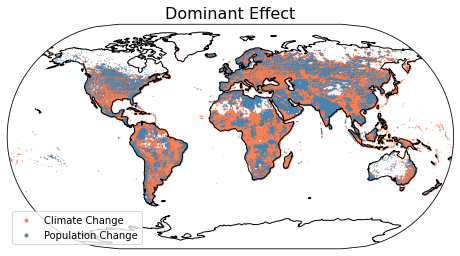

In [23]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs  # Import Cartopy's coordinate reference systems

# Assuming dominant_effect_gdf_elderly is your GeoDataFrame for the elderly population
# and it has a column named 'dominant_effect'

# Filter the GeoDataFrame for each dominant effect
population_growth_dominant = dominant_effect_gdf_elderly[dominant_effect_gdf_elderly['dominant_effect'] == 'Population Change']
climate_effect_dominant = dominant_effect_gdf_elderly[dominant_effect_gdf_elderly['dominant_effect'] == 'Climate Change']

# Create the plot with Cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': MAP_PROJECTION})
ax.coastlines()  # Add coastlines

# Transform the geometries to the correct projection with `.to_crs()`
climate_effect_dominant.to_crs(epsg=4326).plot(ax=ax, marker='o', color='coral', markersize=0.01, label='Climate Change', categorical=True, alpha=1, transform=ccrs.PlateCarree())
population_growth_dominant.to_crs(epsg=4326).plot(ax=ax, marker='o', color='steelblue', markersize=0.01, label='Population Change', categorical=True, alpha=1, transform=ccrs.PlateCarree())

# Customize the plot
ax.set_title('Dominant Effect')
ax.set_global()  # Optionally set a global extent

# Increase the size of the points in the legend
plt.legend(markerscale=30)  # Increase marker scale in legend for better visibility

plt.savefig(PATH_FIGURES / "dominant_effect_change_grid_elderlies.jpeg", dpi=1200)


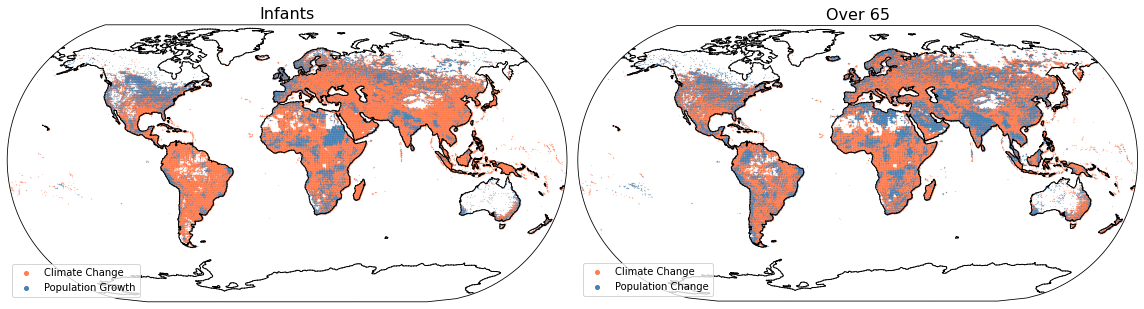

In [31]:
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs  # Import Cartopy's coordinate reference systems
import cartopy

# Assuming dominant_effect_gdf_infants and dominant_effect_gdf_elderly are your GeoDataFrames
# and they have a column named 'dominant_effect'

# Filter the GeoDataFrame for each dominant effect for infants
population_growth_dominant_infants = dominant_effect_gdf_infants[dominant_effect_gdf_infants['dominant_effect'] == 'Population Change']
climate_effect_dominant_infants = dominant_effect_gdf_infants[dominant_effect_gdf_infants['dominant_effect'] == 'Climate Change']

# Filter the GeoDataFrame for each dominant effect for the elderly
population_growth_dominant_elderly = dominant_effect_gdf_elderly[dominant_effect_gdf_elderly['dominant_effect'] == 'Population Change']
climate_effect_dominant_elderly = dominant_effect_gdf_elderly[dominant_effect_gdf_elderly['dominant_effect'] == 'Climate Change']

# Create the plot with Cartopy for both age groups side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), subplot_kw={'projection': MAP_PROJECTION})

# Plot for infants
axs[0].coastlines()  # Add coastlines
climate_effect_dominant_infants.to_crs(epsg=4326).plot(ax=axs[0], marker='o', color='coral', markersize=0.01, label='Climate Change', categorical=True, transform=ccrs.PlateCarree())
population_growth_dominant_infants.to_crs(epsg=4326).plot(ax=axs[0], marker='o', color='steelblue', markersize=0.01, label='Population Growth', categorical=True, transform=ccrs.PlateCarree())
axs[0].set_title('Infants')
axs[0].add_feature(cartopy.feature.COASTLINE, linestyle=':')  # Add country borders for better context
axs[0].legend(markerscale=40)  # Adjust marker scale in legend for better visibility

# Plot for elderly
axs[1].coastlines()  # Add coastlines
climate_effect_dominant_elderly.to_crs(epsg=4326).plot(ax=axs[1], marker='o', color='coral', markersize=0.01, label='Climate Change', categorical=True, transform=ccrs.PlateCarree())
population_growth_dominant_elderly.to_crs(epsg=4326).plot(ax=axs[1], marker='o', color='steelblue', markersize=0.01, label='Population Change', categorical=True, transform=ccrs.PlateCarree())
axs[1].set_title('Over 65')
axs[1].add_feature(cartopy.feature.COASTLINE, linestyle=':')  # Add country borders for better context
axs[1].legend(markerscale=40)  # Adjust marker scale in legend for better visibility

# Optionally, set a global extent for both plots (or adjust as needed)
# axs[0].set_global()
# axs[1].set_global()

plt.tight_layout()  # Adjust the layout to make sure everything fits without overlapping
plt.savefig(PATH_FIGURES / "combined_dominant_effect_change_grid.jpeg", dpi=1200)


In [58]:
import geopandas as gpd
from shapely.geometry import Point
countries_raster = xr.open_dataset(DATA_SRC / 'lancet' / 'admin_boundaries' / 'admin0_raster_report_2024.nc')
land_mask = countries_raster['OBJECTID'] <2000

climate_change = (climate_period2 - climate_period1)
climate_change = climate_change.assign_coords(longitude=(((climate_change.longitude + 180) % 360) - 180))
climate_change = climate_change * land_mask
climate_change_gdf = climate_change.to_dataframe('').reset_index()

geometry = [Point(xy) for xy in zip(climate_change_gdf.longitude, climate_change_gdf.latitude)]
climate_change_gdf = gpd.GeoDataFrame(climate_change_gdf, crs="EPSG:4326", geometry=geometry)


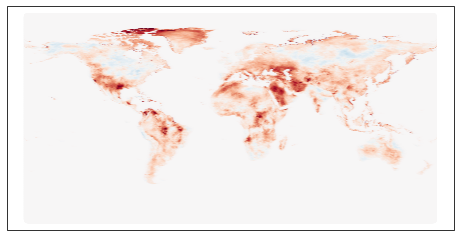

In [62]:
import cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': MAP_PROJECTION})
climate_change_gdf.plot('', cmap='RdBu_r', vmin=-20, vmax=20, ax=ax)

ax.coastlines()


In [60]:
climate_period2_ = climate_period2.assign_coords(longitude=(((climate_period2.longitude + 180) % 360) - 180)).sortby('longitude', ascending=False)
climate_period2_ = climate_period2_ * land_mask
climate_period2_gdf = climate_period2_.to_dataframe('').reset_index()

geometry = [Point(xy) for xy in zip(climate_period2_gdf.longitude, climate_period2_gdf.latitude)]
climate_period2_gdf = gpd.GeoDataFrame(climate_period2_gdf, crs="EPSG:4326", geometry=geometry)


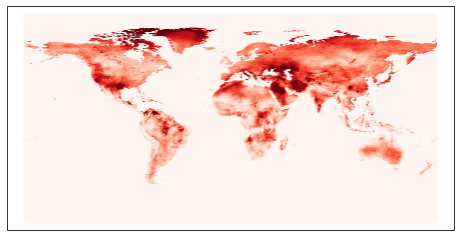

In [61]:
import cartopy
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': MAP_PROJECTION})

climate_period2_gdf.plot('', cmap='Reds', vmin=0, vmax=20, ax=ax)

ax.coastlines()
